<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-2/blob/main/RESULTADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo IA en la comunidad de La Rioja, equipo 2
Dataset: https://unirioja-my.sharepoint.com/:u:/g/personal/joheras_unirioja_es/EbmPj-gacuJMrllR3FsP1IcBSvAh5dDfD7VdZQDkyWjMNA?e=qAKxPT 

#Librerías utilizadas


In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
!pip install pymupdf               #Para el conversor de PDF a Imagen
import fitz                        #Para el conversor de PDF a Imagen
import cv2                         #Para tratamiento de imagenes
import matplotlib.pyplot as plt    #Para mostrar las imagenes
import imutils                     #Para alinear imágenes
from imutils.contours import sort_contours
from collections import namedtuple #Para las localizaciones ocr
import os                          #Para trabajar con los archivos
import pytesseract                  
import numpy as np    


#Funciones utilizadas

##Función mostrar imagen


In [3]:
def mostrarImagen(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.figure(figsize = (200,20))
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.figure(figsize = (180,18))
        plt.imshow(img2,cmap='gray')
        plt.show()

##Conversor de PDF a Imagen

In [4]:
#La función recibe tres strings, convierte el fichero x.pdf en dos imágenes x_0.png y x_1.png (Una por cada página)
def conversorPDF_PNG(nombreFichero, pathOrigen, pathDestino):
  doc = fitz.open(pathOrigen+nombreFichero)
  for pg in range(doc.pageCount):
        page = doc[pg]
        rotate = int(0)
            # El factor de escala para cada tamaño es 2, lo que generará una imagen con cuatro veces la resolución para nosotros.
        zoom_x = 2.0
        zoom_y = 2.0
        trans = fitz.Matrix(zoom_x, zoom_y).preRotate(rotate)
        pm = page.getPixmap(matrix=trans, alpha=False)
        nombreFichero=nombreFichero.split('.')[0]
        name = nombreFichero+"_"+str(pg)+".png"
        pm.writePNG(pathDestino+name)


##Función para alinear imágenes

In [23]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

def alignImages(im1, im2):

  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)

  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)

  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]

  # Draw top matches
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  cv2.imwrite("matches.jpg", imMatches)

  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv2.warpPerspective(im1, h, (width, height))

  #mostrarImagen(imMatches)
  return im1Reg

##Concatenar imágenes

In [6]:
def concatenarImagenes(img1, img2): 
  return cv2.vconcat([img1, img2])

##Filtro para OCR

In [7]:
def aplicaFiltro(imagen):
  r,g,b = cv2.split(imagen) #Canal blue en gris
  th = cv2.adaptiveThreshold(b,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,7) #threshold
  resultado=cv2.fastNlMeansDenoising(th, [50]) #Eliminación de ruido
  return resultado

#Instrucciones / Pasos seguidos


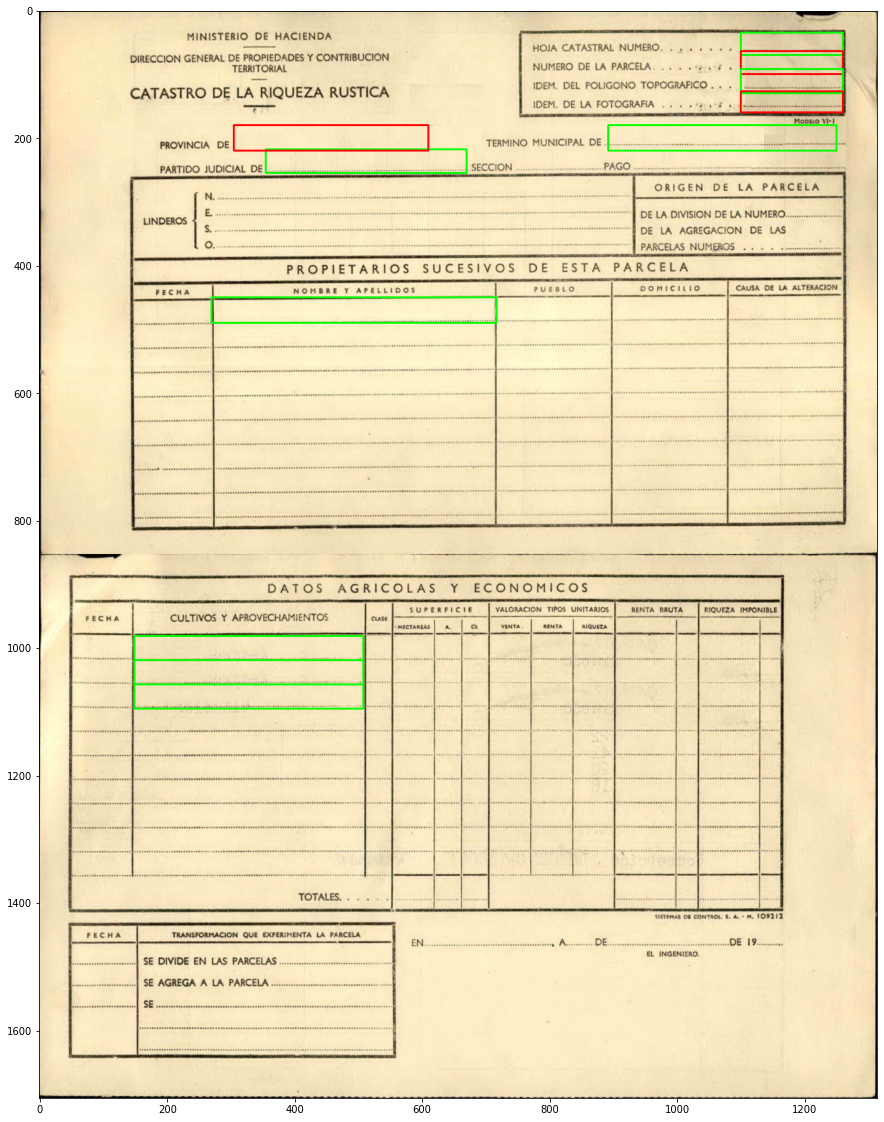

In [8]:
plantilla1=cv2.imread("plantilla_0.png")
plantilla2=cv2.imread("plantilla_1.png")
plantilla= concatenarImagenes(plantilla1,plantilla2)
#Buscamos que campos queremos leer con la plantilla
clone=plantilla.copy()
cv2.rectangle(clone, (892, 180), (1250, 220), (0, 255, 0), 2) #Termino municipal de
cv2.rectangle(clone, (355, 218), (670, 255), (0, 255, 0), 2) #Partido judicial de
cv2.rectangle(clone, (305, 180), (610, 220), (0, 0, 255), 2) #Provincia de

cv2.rectangle(clone, (1100, 35), (1260, 70), (0, 255, 0), 2) #Hoja catastral número
cv2.rectangle(clone, (1100, 64), (1260, 100), (0, 0, 255), 2) #número de la parcela
cv2.rectangle(clone, (1100, 92), (1260, 130), (0, 255, 0), 2) #idem del poligono topográfico
cv2.rectangle(clone, (1100, 127), (1260, 160), (0, 0, 255), 2) #idem de la fotografía

cv2.rectangle(clone, (270, 450), (717, 490), (0, 255, 0), 2) #Propietario1

cv2.rectangle(clone, (149, 981), (508, 1019), (0, 255, 0), 2) #Cultivos y aprobechamientos 1
cv2.rectangle(clone, (149, 1019), (508, 1057), (0, 255, 0), 2) #Cultivos y aprobechamientos 2
cv2.rectangle(clone, (149, 1057), (508, 1095), (0, 255, 0), 2) #Cultivos y aprobechamientos 3
mostrarImagen(clone)

In [9]:
def cleanup_text(text):
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [42]:
def imagenATexto(OCR_Locations,imagen):
  #Extraemos los campos:
  parsingResults=[]
  for loc in OCR_Locations:
    (x,y,w,h)=loc.bbox
    roi=imagen[y:y + h, x:x + w]
    copia=roi.copy()

    im,exito=recorte(copia)

    if exito:
      #text=pytesseract.image_to_string(im, config="-c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8")
      text=pytesseract.image_to_string(im, config="--psm 8")

      parsingResults.append((loc,text))
    else:
      text=" "

  results={}

  for(loc,line) in parsingResults:
    r=results.get(loc.id,None)

    if r is None:
      results[loc.id]=(line,loc._asdict())
    else:
      (existingText,loc)=r
      text="{}\n".format(existingText,line)

      results[loc["id"]]=(text,loc)
  for (locID,result) in results.items():
    (text,loc)=result
    clean=cleanup_text(text)
    print(loc["id"])
    print("=" * len(loc["id"]))
    print("{}\n\n".format(clean))
    (x,y,w,h)=loc["bbox"]
    
    cv2.rectangle(imagen,(x,y),(x+w,y+h),(0,255,0,2))
    #for (i,text) in enumerate(text.split("\n")):
    startY=y+40
    cv2.putText(imagen,text,(x,startY),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,255),2)
  mostrarImagen(imagen)

In [25]:
def recorte(imagen):
  gray = aplicaFiltro(imagen)
  ret,thresh1 = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)  
  cnts = cv2.findContours(thresh1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)

  #chars = []
  xs=[]
  ys=[]
  x1=0
  y1=0
  hs=[]
  ws=[]
  w1=0
  h1=0
  for c in cnts: 
    (x, y, w, h) = cv2.boundingRect(c)
    if w >=5  and h >= 5 and w<100 and h<30:
      xs.append(x)
      ys.append(y)
      hs.append(h)
      ws.append(w)
      #chars.append(c)
  maximosy=[]
  maximosx=[]
  i=0
  while i<len(hs):
    maximosy.append(ys[i]+hs[i])
    maximosx.append(xs[i]+ws[i])
    i+=1

  if len(xs)>0:
    x1=min(xs)
    #print(ys)
    y1=min(ys)
    h1=max(maximosy)-y1
    #print(hs)
    w1=max(maximosx)-x1
    #print(xs)
  clone = imagen.copy()
  #cv2.drawContours(clone, chars, -1, (0, 255, 0), 2)
  #mostrarImagen(clone)
  if y1>0 and x1>0:
    im=imagen[y1:y1 + h1, x1:x1 + w1]
    return (im,True)
  else:
    return (None,False)

#Función completa
La función que realiza todos los pasos explicados en la seccion intrucciones, la función recibe un fichero pdf y devuelve un texto con la información extraida

In [40]:
#Para utilizar la función simplemente hay que subir las plantillas al path con los nombres plantilla_0.png
# y plantilla_1.png y el fichero del que queremos hacer OCR, despues pasar a esta función el nombre del fichero:
def OCR(nombreDocumento):
  #Converte el pdf en dos imagenes:
  conversorPDF_PNG(nombreDocumento,'','')
  nombreDocumento=nombreDocumento.split('.')[0]
  #Leemos las 2 images del documento
  fichero1=cv2.imread(nombreDocumento+"_0.png")
  fichero2=cv2.imread(nombreDocumento+"_1.png")

  #Leemos las dos imagenes de la plantilla
  plantilla1=cv2.imread("plantilla_0.png")
  plantilla2=cv2.imread("plantilla_1.png")

  #Alineamos las dos hojas de cada documento con respecto a las plantillas, nos devuelve dos imagenes ya alineadas:
  alineada1=alignImages(fichero1,plantilla1)
  alineada2=alignImages(fichero2,plantilla2)

  #Juntamos las dos imagenes en una sola imagen para realizar el ocr:
  fichero = concatenarImagenes(fichero1,fichero2)
  plantilla = concatenarImagenes(plantilla1,plantilla2)

  #Eliminamos los ficheros auxiliares que se han ido creando el el path:
  os.remove(nombreDocumento+"_0.png")
  os.remove(nombreDocumento+"_1.png")


  #Definimos la posición de las localizaciones que queremos leer mediante una tupla
  OCRLocation = namedtuple ( "OCRLocation" , [ "id" , "bbox" ])
  OCR_Locations=[
    OCRLocation("termino municipal",(892,180,358,40)),
    OCRLocation("partido judicial",(355,218,315,37)),
    OCRLocation("provincia",(305,180,305,40)),
    
    OCRLocation("numero de hoja catastral",(1100,35,160,35)),
    OCRLocation("numero de parcela",(1100,64,160,36)),
    OCRLocation("idem del poligono",(1100,92,160,38)),
    #OCRLocation("idem de la fotografia",(1100,127,160,33)),

    OCRLocation("propietario 1",(270, 450,447,40)),
    #OCRLocation("propietario 2",(270, 490,447,40)),
    #OCRLocation("propietario 3",(270, 530,447,35)),
    
    OCRLocation("cultivos 1",(149,981,359,38)),
    OCRLocation("cultivos 2",(149,1019,359,38)),
    OCRLocation("cultivos 3",(149,1057,359,38))
  ]

  #Aplicamos el filtro para procesar los textos de cada campo:
  #imagenFiltrada = aplicaFiltro(fichero)
  #Mostramos el resultado:
  #mostrarImagen(imagenFiltrada)
  #mostrarImagen(imagenFiltrada)
  imagenATexto(OCR_Locations,fichero)

termino municipal
BRIEVA


partido judicial
NA BRA


provincia
LOGRONO


numero de parcela
218


idem del poligono
2


propietario 1
YNionisio FERNANDEZ FERNANDEZ


cultivos 1
Pastizal u




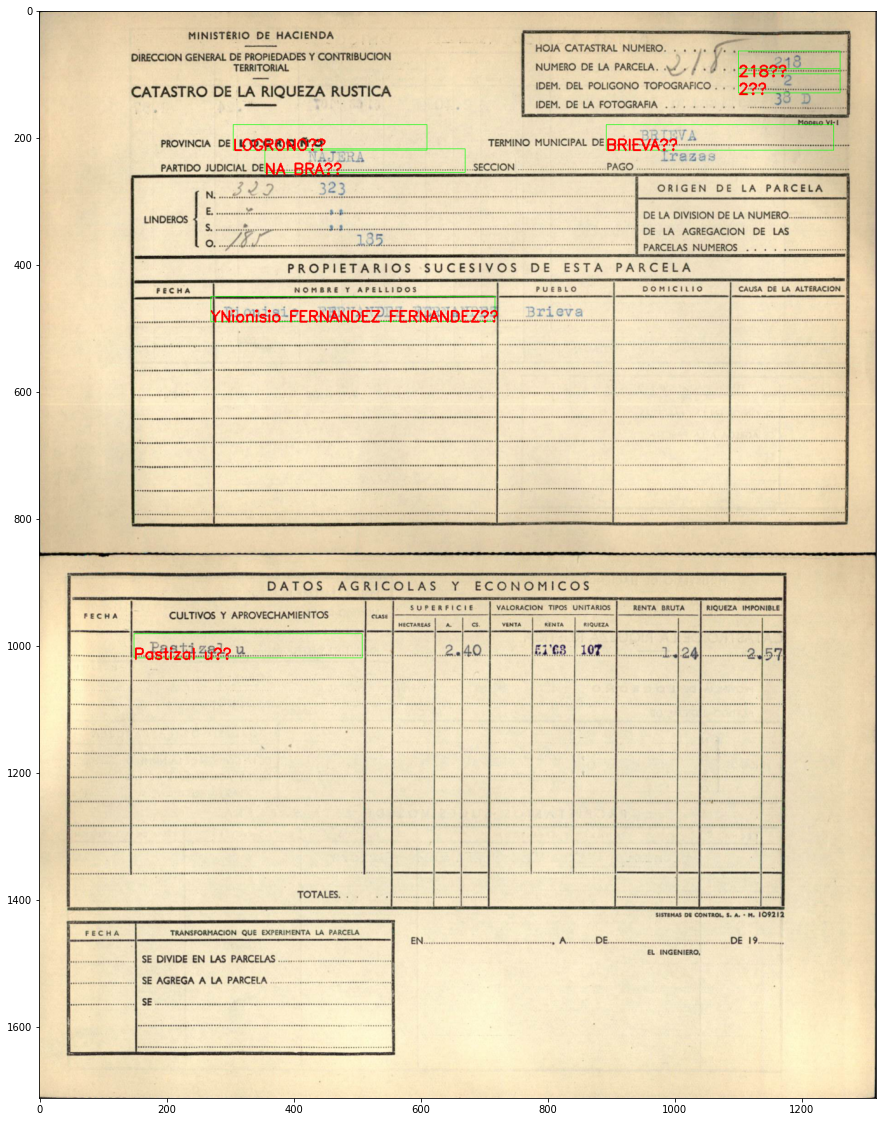

In [43]:
#Prueba de la función
OCR('fichero1.pdf')

termino municipal
BRIEVA


partido judicial
NAJ ERA


provincia
lLOGRONO


numero de parcela
L173


idem del poligono
2


propietario 1
lTgyabel DAVILA FRERNANDDZ


cultivos 1
Cereal S,cano 38




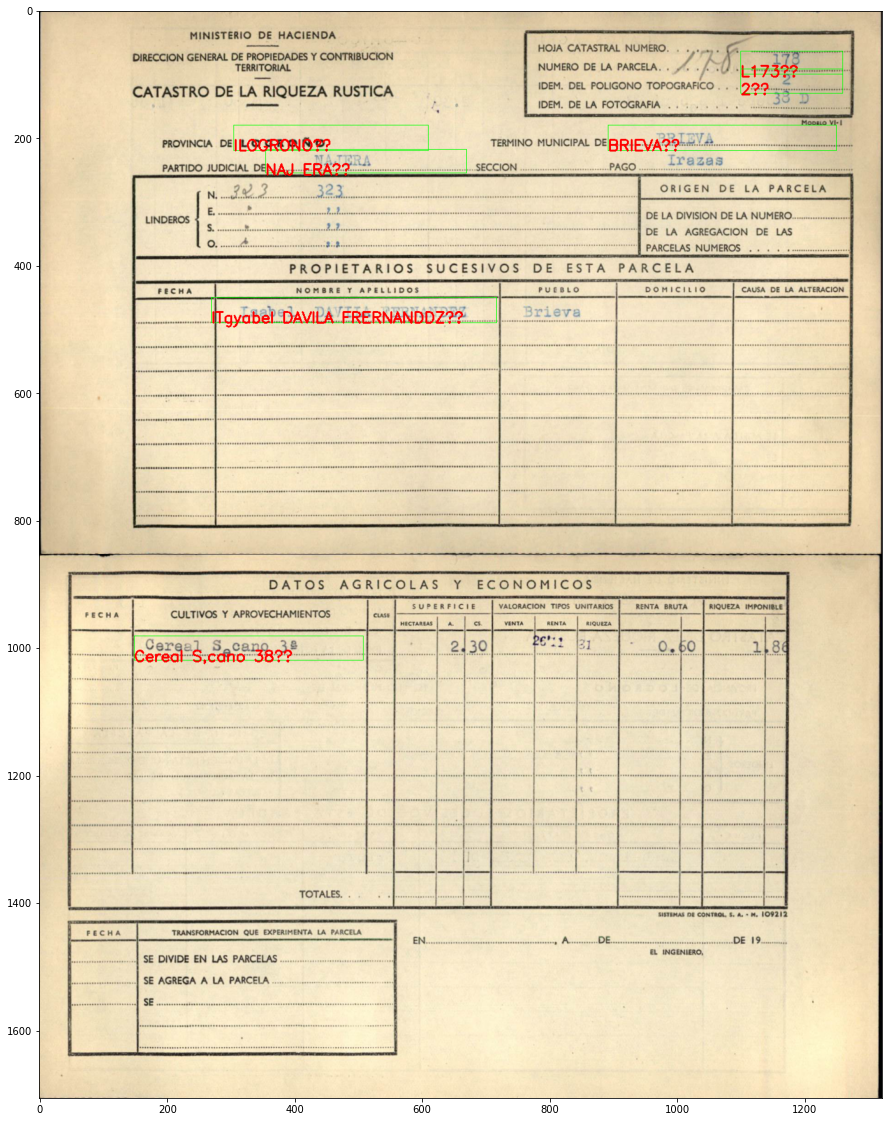

In [44]:
OCR('fichero2.pdf')